In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
from scipy import stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
# importing my personal wrangle module
import wrangle

In [3]:
# Acquiring the data using the above module
zillow_sql_query = wrangle.get_zillow_data()
# PLEASE THINK ABOUT ADDING A ZILLOW_COPY TO WORK WITH FROM HERE, THEREBY AVOIDING FUTURE SQL QUERIES
# Code below will have to be updated accordingly.  
zillow = zillow_sql_query.copy()

In [4]:
zillow.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0


In [5]:
# Using my wrangle module to clean and prep the data. NaNs are dropped; so are outliers. 
# In the end, I added an 'age' column and deleted the yearbuilt column (which was more like a categorical variable)
# No outliers were removed from year built, age, or fips
zillow = wrangle.clean_and_prep_data(zillow)

Consider dropping yearbuilt as a column--this is a categorical and is closely related to age, which will be the feature we use instead.

Consider the k value used removing outliers--there are a couple features that may be better with a different value.  I'm thinking of the 1 bedroom houses, for example.

In [6]:
zillow.head()

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom
0,4.0,3.5,3100.0,1023282.0,Orange,23,885.714286
1,2.0,1.0,1465.0,464000.0,Ventura,54,1465.000000
2,3.0,2.0,1243.0,564778.0,Orange,59,621.500000
3,4.0,3.0,2376.0,145143.0,LA,51,792.000000
4,4.0,3.0,2962.0,773303.0,LA,71,987.333333


In [7]:
zillow.shape, zillow_sql_query.shape
# my clean_and_prep function is cutting down the size here, it wasn't me

((44864, 7), (52442, 7))

In [8]:
zillow_sql_query.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0


In [9]:
zillow_sql_query.isna().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet     82
taxvaluedollarcnt                 1
yearbuilt                       116
taxamount                         4
fips                              0
dtype: int64

In [7]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44864 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            44864 non-null  float64
 1   bathrooms           44864 non-null  float64
 2   sq_ft               44864 non-null  float64
 3   tax_value           44864 non-null  float64
 4   county              44864 non-null  object 
 5   age                 44864 non-null  int64  
 6   sq_ft_per_bathroom  44864 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.7+ MB


In [8]:
# checking for null values
zillow.isnull().sum()

bedrooms              0
bathrooms             0
sq_ft                 0
tax_value             0
county                0
age                   0
sq_ft_per_bathroom    0
dtype: int64

In [9]:
# This is a for loop that is checking every column for any white space. there isn't any
# also the NaNs, actually. gone now.
cols = ['bedrooms', 'bathrooms', 'sq_ft', 'tax_value', 'county','age']
for col in cols:
    print(zillow[col].value_counts(dropna=False,ascending=True))

5.0     2255
2.0     7981
4.0    12802
3.0    21826
Name: bedrooms, dtype: int64
3.5      422
1.5      832
4.0      960
2.5     3708
1.0     8846
3.0     9108
2.0    20988
Name: bathrooms, dtype: int64
552.0       1
3202.0      1
468.0       1
3498.0      1
3493.0      1
         ... 
1040.0     84
936.0      86
1080.0    100
1200.0    116
1120.0    127
Name: sq_ft, Length: 2905, dtype: int64
134063.0     1
651170.0     1
509145.0     1
474661.0     1
437595.0     1
            ..
550000.0    23
450000.0    23
500000.0    24
600000.0    30
455000.0    33
Name: tax_value, Length: 32879, dtype: int64
Ventura     3828
Orange     11835
LA         29201
Name: county, dtype: int64
127       1
143       1
141       1
124       1
139       1
5         2
134       2
122       2
133       3
128       3
123       5
136       5
125       5
131       6
121       9
119      11
126      12
120      13
117      15
118      17
105      32
6        33
114      36
104      37
87       41
88       42
103 

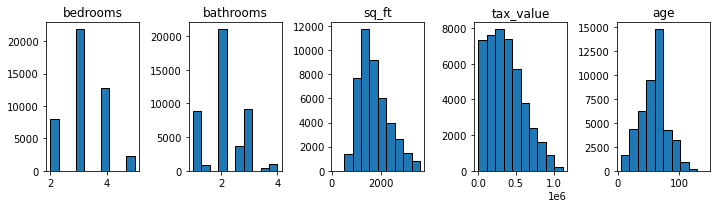

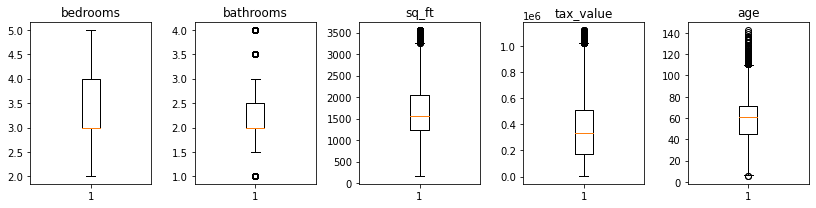

In [10]:
# Here, we create a for loop that makes a histogram for every column. This is the start of my univariate analysis

plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms','sq_ft','tax_value', 'age']
# Note the enumerate code, which is functioning to make a counter for use in successive plots.

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,8, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    zillow[col].hist(bins=10, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)
    
    plt.tight_layout()
    
,

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,7, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    plt.boxplot(zillow[col])
    
    # Hide gridlines.
    plt.grid(False)
    
    plt.tight_layout()

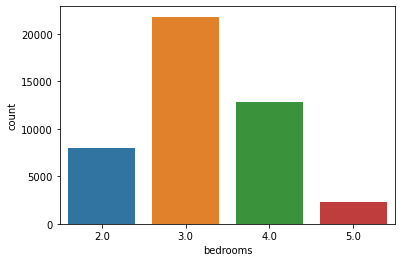

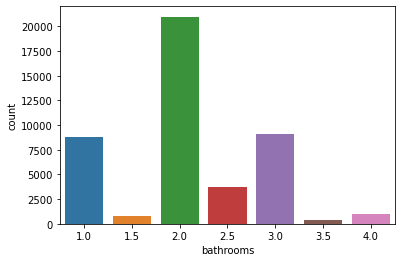

In [11]:
disc_vars = ['bedrooms','bathrooms']
for var in disc_vars:
    plt.figure()
    sns.countplot(x=var,data=zillow)

In [12]:
# Describe was displaying with scientific notation, so I rounded to 2 places.  
round(zillow.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
bedrooms,44864.0,3.21,0.79,2.0,3.0,3.0,4.0,5.0
bathrooms,44864.0,2.09,0.72,1.0,2.0,2.0,2.5,4.0
sq_ft,44864.0,1694.01,605.61,152.0,1238.0,1568.0,2050.0,3566.0
tax_value,44864.0,363580.89,233629.59,1000.0,171473.0,331368.0,511394.0,1122409.0
age,44864.0,58.98,21.62,5.0,45.0,61.0,71.0,143.0
sq_ft_per_bathroom,44864.0,840.16,227.00,76.0,683.0,803.0,955.0,3438.0


### Notice the minimum bedrooms is 2.  I'm sure there were some useful one bedrooms before I removed the outliers.
### The minimum of 1 square foot isn't correct and should be addressed after arriving at MVP.  However, see the problems i was having figuring that out below.  moving on 
### These are homes around in Los Angeles, Ventura, and Orange County, CA

## Next steps: encode columns and split
### Encode the following:
- ['bedroomcnt','bathroomcnt','fips'] .... on second thought, only encode fips
- I will not use the yearbuilt in the final analysis, and instead use age, which is almost the same thing for my purposes.

In [13]:
encoded = wrangle.encode_zillow(zillow)
encoded.head().T

,0,1,2,3,4
bedrooms,4.0,2.0,3.0,4.0,4.0
bathrooms,3.5,1.0,2.0,3.0,3.0
sq_ft,3100.0,1465.0,1243.0,2376.0,2962.0
tax_value,1023282.0,464000.0,564778.0,145143.0,773303.0
county,Orange,Ventura,Orange,LA,LA
age,23,54,59,51,71
sq_ft_per_bathroom,885.714286,1465.0,621.5,792.0,987.333333
LA,0,0,0,1,1
Orange,1,0,1,0,0
Ventura,0,1,0,0,0


| Variable    | Meaning     |
| ----------- | ----------- |
|
|bedrooms:   |   The number of bedrooms|
|bathrooms:   |  The number of bathrooms|
|sq_ft:   |   How many square feet |
|tax_value:   |  The tax value of the home |
|county:   |  What county does it belong to |
|age:   |   How old is it? |
|sq_ft_per_bathroom:   |  How many square feet per bathroom? |
|LA:   |  Belongs to Los Angeles county |
|Orange:   | Belongs to Orange county |
|Ventura:   | Belings to Ventura county |

# SPLITTING

In [14]:
train, validate, test,X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_zillow(encoded)
train.shape, validate.shape, test.shape,X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((25123, 10),
 (10768, 10),
 (8973, 10),
 (25123, 9),
 (25123, 1),
 (10768, 9),
 (10768, 1),
 (8973, 9),
 (8973, 1))

# SCALING
### I've done it in this order so I can explore different data sets as is appropriate

In [15]:
train_scaled, X_train_scaled, y_train_scaled, \
validate_scaled, X_validate_scaled, y_validate_scaled, \
test_scaled, X_test_scaled, y_test_scaled = wrangle.scale_zillow(train, validate, test)


In [16]:
# train_scaled, X_train_scaled, y_train_scaled, \
# validate_scaled, X_validate_scaled, y_validate_scaled, \
# test_scaled, X_test_scaled, y_test_scaled

# DATA EXPLORATION--BIVARIATE AND MULTIVARIATE

## I decided to rely on an unencoded version of the data set for some of my visual exploration.

In [17]:
train.head(1)

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom,LA,Orange,Ventura
44364,3.0,2.0,2525.0,347114.0,LA,84,1262.5,1,0,0


<AxesSubplot:xlabel='county', ylabel='tax_value'>

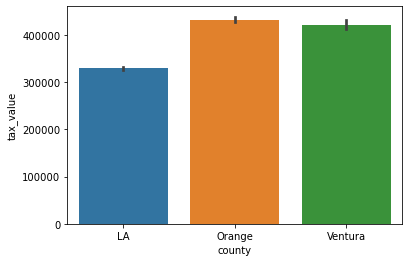

In [18]:
sns.barplot(x=train.county, y=train.tax_value)

<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

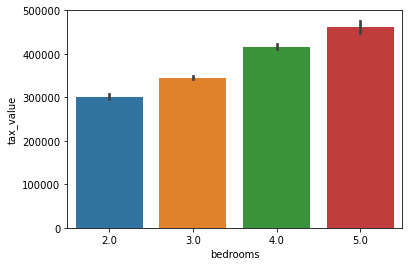

In [19]:
sns.barplot(x=train.bedrooms, y=train.tax_value)

<AxesSubplot:xlabel='bathrooms', ylabel='tax_value'>

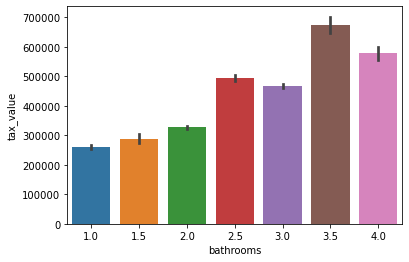

In [20]:
sns.barplot(x=train.bathrooms, y=train.tax_value)

### There are definitely some houses with too many bathrooms.

In [21]:
train.head()

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom,LA,Orange,Ventura
44364,3.0,2.0,2525.0,347114.0,LA,84,1262.50,1,0,0
46624,4.0,2.0,1337.0,500000.0,Orange,67,668.50,0,1,0
11864,3.0,4.0,2881.0,757360.0,LA,69,720.25,1,0,0
15449,2.0,1.0,1397.0,520117.0,Orange,74,1397.00,0,1,0
25692,2.0,1.0,1103.0,137886.0,LA,116,1103.00,1,0,0


In [22]:
train_corr = train.corr()
train_corr

,bedrooms,bathrooms,sq_ft,tax_value,age,sq_ft_per_bathroom,LA,Orange,Ventura
bedrooms,1.000000,0.576718,0.601812,0.195023,-0.362819,-0.021169,-0.165845,0.115987,0.100895
bathrooms,0.576718,1.000000,0.772926,0.361056,-0.555708,-0.400877,-0.182372,0.151598,0.072516
sq_ft,0.601812,0.772926,1.000000,0.433543,-0.482633,0.219965,-0.187900,0.149789,0.084948
tax_value,0.195023,0.361056,0.433543,1.000000,-0.236007,0.055188,-0.203451,0.173809,0.073408
age,-0.362819,-0.555708,-0.482633,-0.236007,1.000000,0.205633,0.345451,-0.268278,-0.167530
sq_ft_per_bathroom,-0.021169,-0.400877,0.219965,0.055188,0.205633,1.000000,0.061560,-0.056600,-0.015806
LA,-0.165845,-0.182372,-0.187900,-0.203451,0.345451,0.061560,1.000000,-0.821659,-0.412970
Orange,0.115987,0.151598,0.149789,0.173809,-0.268278,-0.056600,-0.821659,1.000000,-0.179785
Ventura,0.100895,0.072516,0.084948,0.073408,-0.167530,-0.015806,-0.412970,-0.179785,1.000000


<AxesSubplot:>

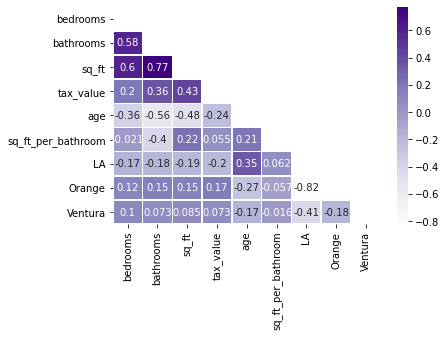

In [23]:
sns.heatmap(train_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(train_corr))

### I'd like to show the relationship betwwn sq_ft and bathrooms, and maybe create a feature called bathrooms/sq_ft or something like that

<AxesSubplot:xlabel='bathrooms', ylabel='sq_ft'>

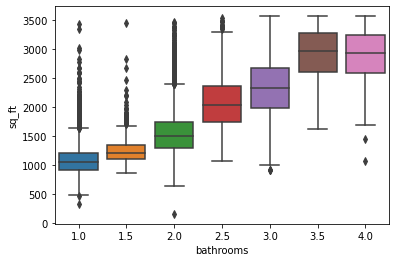

In [24]:
sns.boxplot(x='bathrooms', y='sq_ft', data=train)

In [25]:
train.bathrooms.value_counts()

2.0    11783
3.0     5084
1.0     4956
2.5     2061
4.0      529
1.5      464
3.5      246
Name: bathrooms, dtype: int64

In [26]:
baths_2 = train[train.bathrooms == 2.00].sq_ft
baths_1 = train[train.bathrooms == 1.00].sq_ft
baths_3 = train[train.bathrooms == 3.00].sq_ft
baths_2_5 = train[train.bathrooms == 2.50].sq_ft
baths_4 = train[train.bathrooms == 4.00].sq_ft
baths_1_5 = train[train.bathrooms == 1.50].sq_ft
baths_3_5 = train[train.bathrooms == 3.50].sq_ft

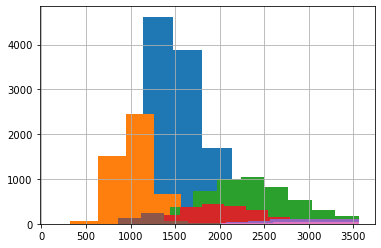

In [27]:
baths_list = [baths_2, baths_1, baths_3, baths_2_5,baths_4,baths_1_5,baths_3_5]#, 'baths_3', 'baths_2_5','baths_4','baths_1_5','baths_3_5','baths_1_75']

for bath in baths_list:
    plt.figure
    bath.hist();

In [28]:
# check variances
for bath in baths_list:
    print(bath.var())
    
# they differ

115053.3907628811
73232.96691576087
237156.8394624062
193107.49698562815
200717.34732485522
74290.53161074709
201218.9193462751


Set Hypothesis
- 𝐻0 : Population means of sq_ft (by bathrooms) counts are equal
- 𝐻𝑎 : Population means of sq_ft (by bathrooms) are not all equal

In [29]:
f, p = stats.f_oneway(baths_2, baths_1, baths_3, baths_2_5,baths_4,baths_1_5,baths_3_5)
f, p

(6818.1000019266785, 0.0)

In [30]:
alpha = 0.05
if p < alpha:
    print("We reject $H_{0}$")
else:
    print("We fail to reject $H_{0}$")

We reject $H_{0}$


In [31]:
train.head()

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom,LA,Orange,Ventura
44364,3.0,2.0,2525.0,347114.0,LA,84,1262.50,1,0,0
46624,4.0,2.0,1337.0,500000.0,Orange,67,668.50,0,1,0
11864,3.0,4.0,2881.0,757360.0,LA,69,720.25,1,0,0
15449,2.0,1.0,1397.0,520117.0,Orange,74,1397.00,0,1,0
25692,2.0,1.0,1103.0,137886.0,LA,116,1103.00,1,0,0


In [32]:
train.columns

Index(['bedrooms', 'bathrooms', 'sq_ft', 'tax_value', 'county', 'age',
       'sq_ft_per_bathroom', 'LA', 'Orange', 'Ventura'],
      dtype='object')

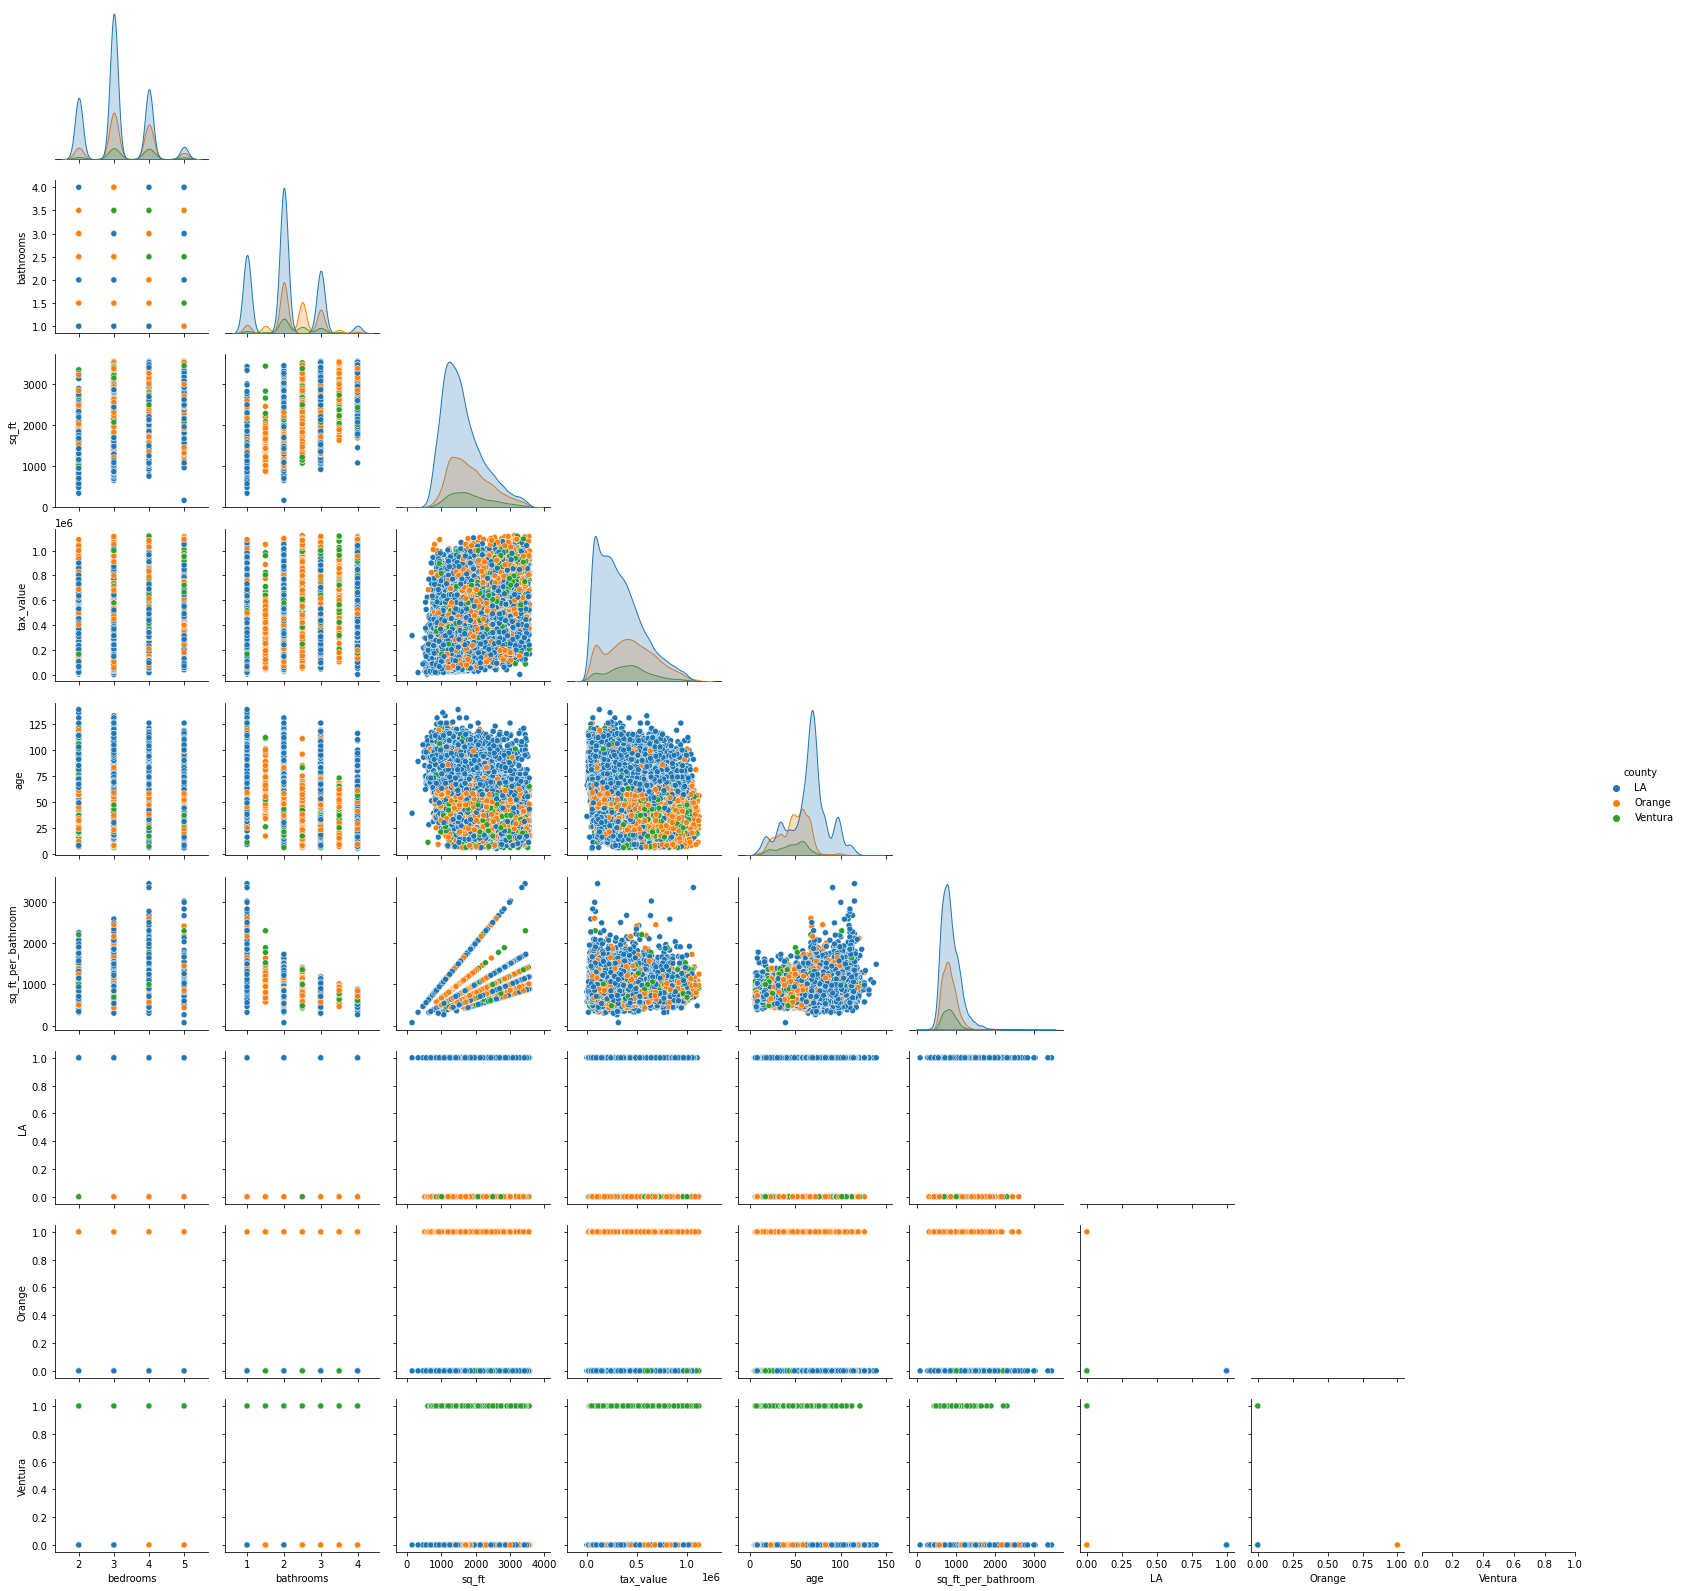

In [33]:
sns.pairplot(data=train,corner=True, hue='county')

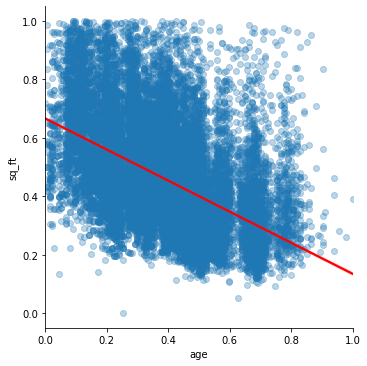

In [34]:
# I can really pop that line color if I want.

sns.lmplot(x='age', y="sq_ft", data=train_scaled, line_kws={'color': 'red'}, scatter_kws={'alpha':.3})
plt.show()

### Newer homes are larger

In [35]:
train.head()

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom,LA,Orange,Ventura
44364,3.0,2.0,2525.0,347114.0,LA,84,1262.50,1,0,0
46624,4.0,2.0,1337.0,500000.0,Orange,67,668.50,0,1,0
11864,3.0,4.0,2881.0,757360.0,LA,69,720.25,1,0,0
15449,2.0,1.0,1397.0,520117.0,Orange,74,1397.00,0,1,0
25692,2.0,1.0,1103.0,137886.0,LA,116,1103.00,1,0,0


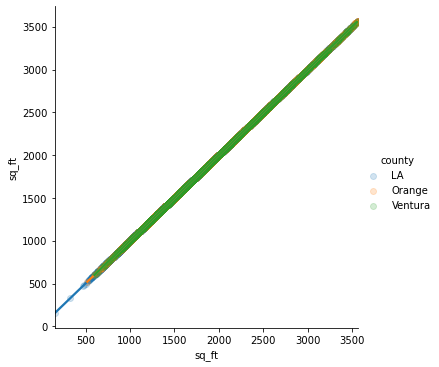

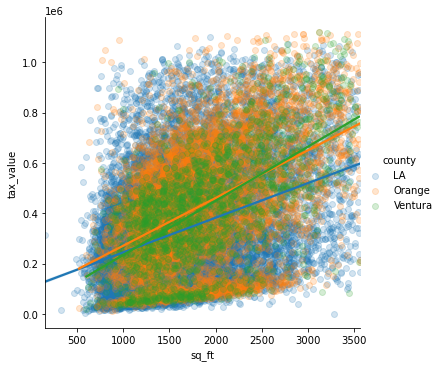

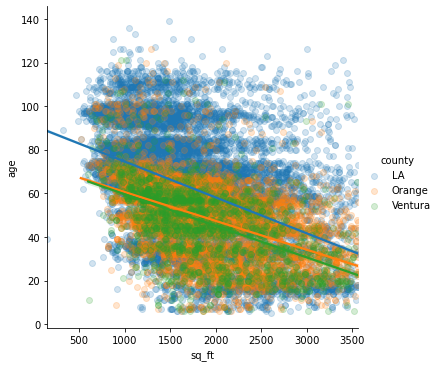

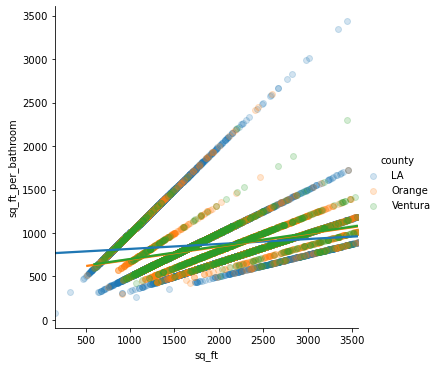

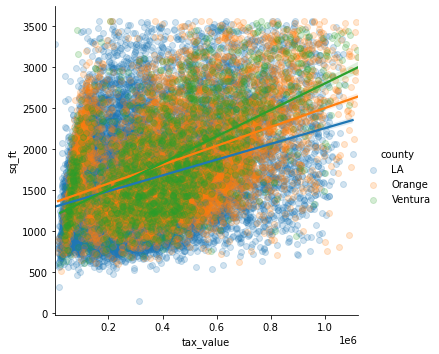

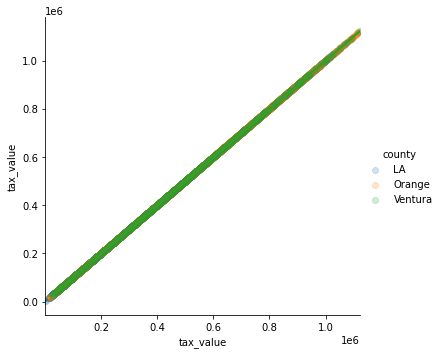

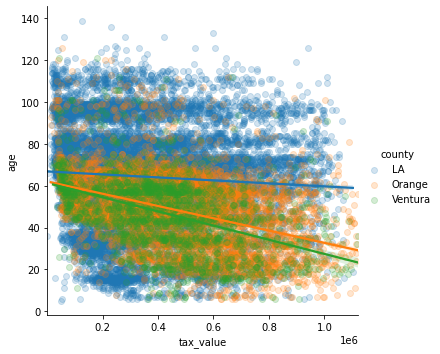

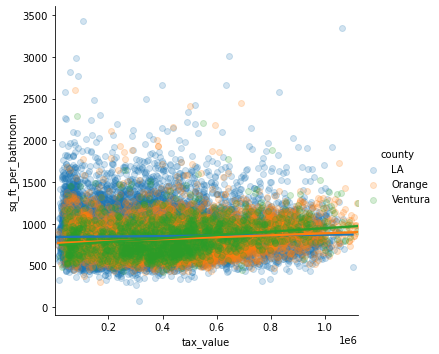

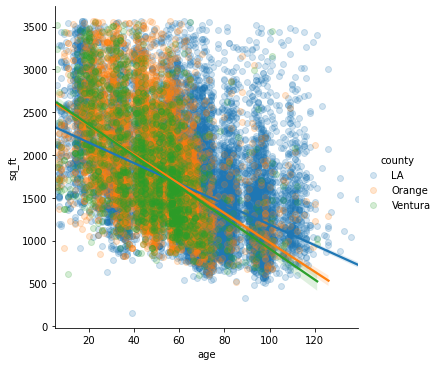

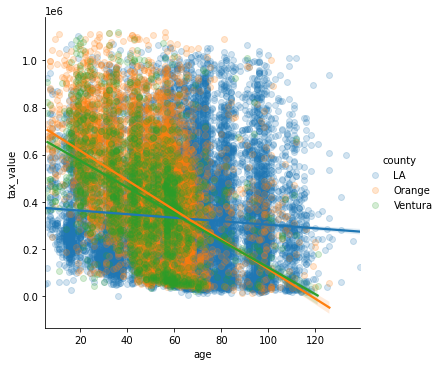

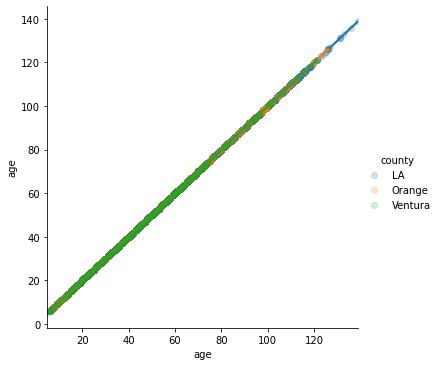

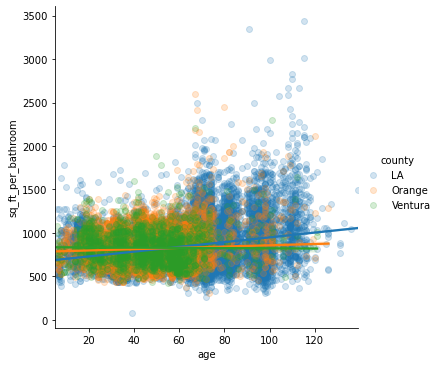

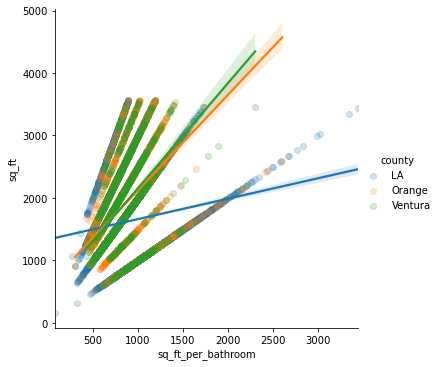

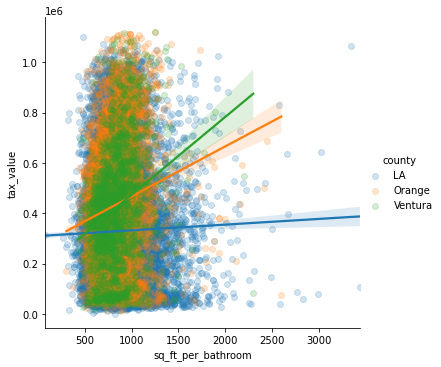

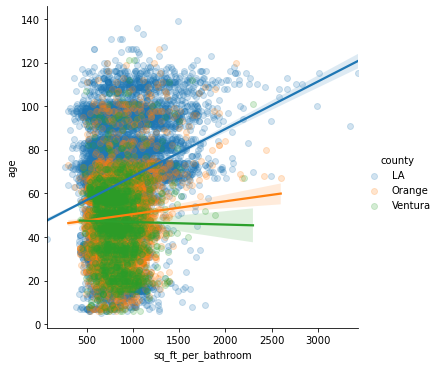

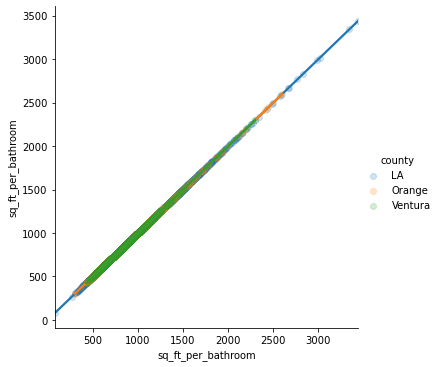

In [36]:
# This cell will take a long time to run but provide lots of good vizes
# Run it with plenty of time
vars = ['sq_ft','tax_value', 'age','sq_ft_per_bathroom']
vars2 = ['sq_ft','tax_value', 'age','sq_ft_per_bathroom']

for var in vars:
    for var2 in vars2:
        plt.figure
        sns.lmplot(x=var, y=var2, data=train, scatter_kws={'alpha':.2},hue='county')#line_kws={'color': 'red'},

### Takeaways:

- Age doesn't affect tax_value so much in LA county--next step: different model for LA county?

- Sq_ft definitely affects tax_value

- Sq_ft_per_bathroom make a much smaller difference re: tax value in LA county; 

- Sq_ft_per_bathroom has a much bigger relationship to age in LA county (as age goes up, so does sfpb).  Are these historic homes that are valued more highly? --> note that older homes do not depreciate as much here



## Research question number 1: 

Are bigger houses valued higher?

<AxesSubplot:title={'center':'There seems to be a positive correlation between square feet and tax_value'}, xlabel='sq_ft', ylabel='tax_value'>

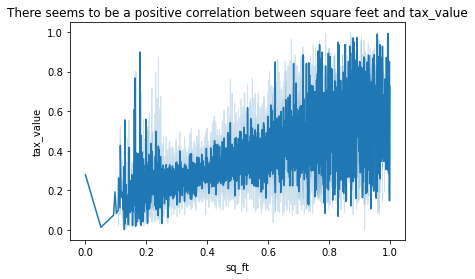

In [37]:
plt.title('There seems to be a positive correlation between square feet and tax_value')
sns.lineplot(x=train_scaled.sq_ft, y=train_scaled.tax_value)#,markers=True)


Hypothesis testing: 

    H_o: Square feet and tax_value are not related
    H_a: Square feet and tax_value are related
    
    The null hypothesis is rejected by the stats test

In [38]:
alpha = 0.05

corr, p = stats.pearsonr(train.sq_ft, train.tax_value)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
corr, p

We reject the null hypothesis


(0.4335428740580575, 0.0)

### There is a moderate correlation between the variables.

## Question number two: is there a relationship between the sq_ft_per_bathroom and value?

In [39]:
train_scaled.head()

,bedrooms,bathrooms,sq_ft,tax_value,age,sq_ft_per_bathroom,LA,Orange,Ventura
0,0.333333,0.333333,0.695079,0.308642,0.589552,0.352915,1.0,0.0,0.0
1,0.666667,0.333333,0.347100,0.444976,0.462687,0.176234,0.0,1.0,0.0
2,0.333333,1.000000,0.799356,0.674473,0.477612,0.191627,1.0,0.0,0.0
3,0.000000,0.000000,0.364675,0.462915,0.514925,0.392921,0.0,1.0,0.0
4,0.000000,0.000000,0.278559,0.122066,0.828358,0.305473,1.0,0.0,0.0


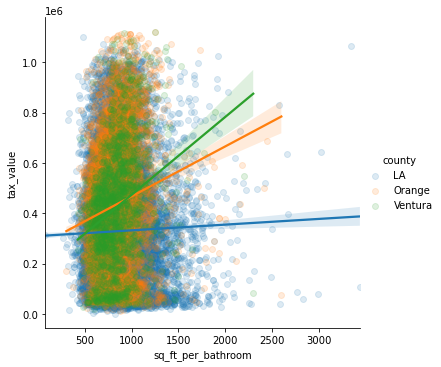

In [40]:
sns.lmplot(x='sq_ft_per_bathroom',y='tax_value',data=train, hue= 'county',scatter_kws={'alpha':.15})

## Big takeaway: sfpb has very little impact on tax value in LA county, but more in the other two counties.  Strong evidence that two models could be handy

### Let's do an 1 tailed t test here to be sure:

Verify Assumptions
Independent Samples. YES! no observations in the LA sample exist in the Orange or Ventura.
Normal Distribution: Basically normal, and huge sample
Equal Variances (the scipy methods we will use has an argument to handle when variances aren't equal).

In [41]:
train.sample(1)

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom,LA,Orange,Ventura
43827,4.0,2.0,1222.0,332682.0,Orange,66,611.0,0,1,0


In [42]:
LA_sample = train[train.county == 'LA']
# Orange_sample = train[[train.county == 'Orange'].tax_value
# Ventura_sample = train[train.county == 'Ventura'].tax_value
Other_counties_sample = train[train.county != 'LA']

In [43]:
LA_sample.head()

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom,LA,Orange,Ventura
44364,3.0,2.0,2525.0,347114.0,LA,84,1262.50,1,0,0
11864,3.0,4.0,2881.0,757360.0,LA,69,720.25,1,0,0
25692,2.0,1.0,1103.0,137886.0,LA,116,1103.00,1,0,0
4412,3.0,1.0,1278.0,253960.0,LA,71,1278.00,1,0,0
20350,2.0,1.0,1360.0,44679.0,LA,91,1360.00,1,0,0


<AxesSubplot:title={'center':"The counties' tax values are normally distributed"}, xlabel='County Bins', ylabel='Tax Value'>

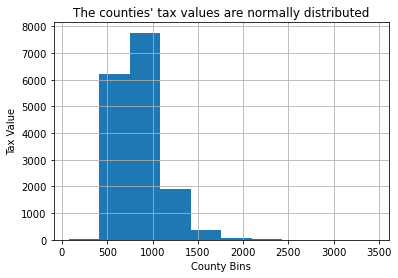

In [44]:
plt.title("The counties' tax values are normally distributed")
plt.xlabel("County Bins")
plt.ylabel("Tax Value")
LA_sample.sq_ft_per_bathroom.hist()

<AxesSubplot:>

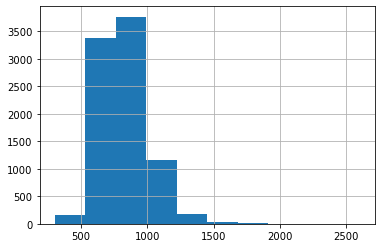

In [45]:
Other_counties_sample.sq_ft_per_bathroom.hist()

In [46]:
# check variances
LA_sample.sq_ft_per_bathroom.var(),Other_counties_sample.sq_ft_per_bathroom.var()

(60053.740329515094, 35051.4165087556)

### Differing variances

Set Hypothesis
- 𝐻0 : In LA county, sfpb does not impact tax value
- 𝐻𝑎 : In LA county, sfpb does impact tax value

In [47]:
corr_LA, p = stats.pearsonr(LA_sample.sq_ft_per_bathroom,LA_sample.tax_value)
corr_LA, p

(0.024920318962505083, 0.0014043736499767124)

In [48]:
corr_Others, p = stats.pearsonr(Other_counties_sample.sq_ft_per_bathroom,Other_counties_sample.tax_value)
corr_Others, p

(0.1738096142789595, 5.566970219475142e-60)

### Takeaway: there is a stronger correlation between sfpb in Other counties than in LA

## Here's a question: Newer homes are larger; they are also valued more highly. Is there an exception to the rule?


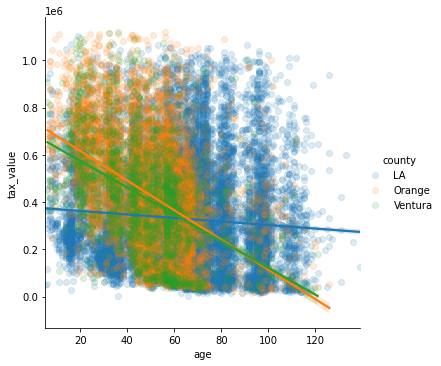

In [49]:
sns.lmplot(x='age',y='tax_value',data=train, hue= 'county',scatter_kws={'alpha':.15})

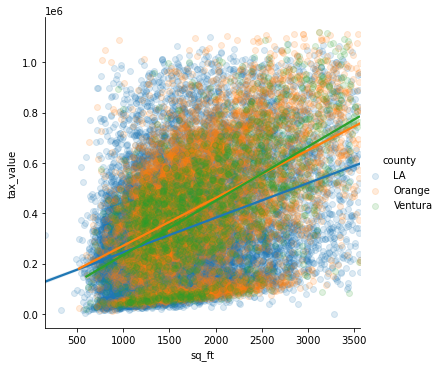

In [50]:
sns.lmplot(x='sq_ft',y='tax_value',data=train, hue= 'county',scatter_kws={'alpha':.15})

### Older homes in LA county don't depreciate as much as in the other counties; nevertheless, larger homes do in fact have a higher tax value there.  

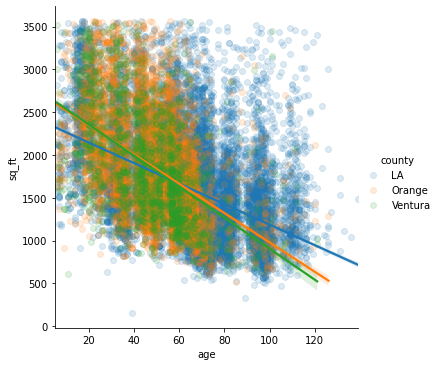

In [51]:
sns.lmplot(x='age',y='sq_ft',data=train, hue= 'county',scatter_kws={'alpha':.15})

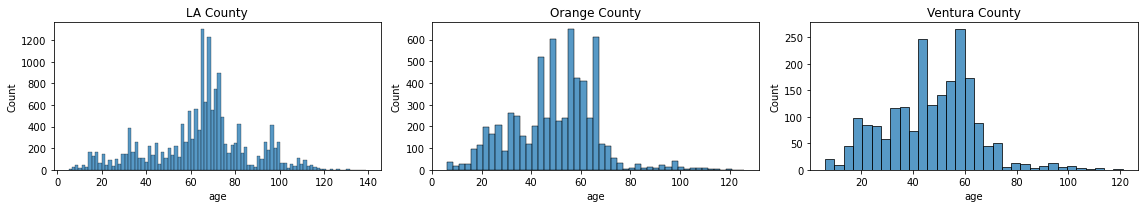

In [52]:
plt.figure(figsize = (16,3))
plt.subplot(1,3, 1)

# Title with column name.
plt.title('LA County')
# Display histogram for column.
#plt.boxplot(train[col])
sns.histplot(data=train[train.county=='LA'].age)
# Hide gridlines.

plt.subplot(1,3, 2)
# Title with column name.
plt.title('Orange County')
# Display histogram for column.
#plt.boxplot(train[col])
sns.histplot(data=train[train.county=='Orange'].age)
# Hide gridlines.

plt.subplot(1,3, 3)
# Title with column name.
plt.title('Ventura County')
# Display histogram for column.
#plt.boxplot(train[col])
sns.histplot(data=train[train.county=='Ventura'].age)
# Hide gridlines.

plt.grid(False)
plt.tight_layout()

### Takeaway: LA county has slightly older homes that have kept their value more than homes in the other counties. Please note the left skew of Orange and Ventura counties (compared to LA)

# Feature engineering

In [53]:
# This cell runs my function in feature_engineering.py that selects for the top 'k' number of features
import feature_engineering
f_feature = feature_engineering.select_kbest(X_train_scaled,y_train, 3)
f_feature

['bathrooms', 'sq_ft', 'age']

In [54]:
# # K Best model here:

# from sklearn.feature_selection import SelectKBest, f_regression

# # parameters: f_regression stats test, give me 8 features
# f_selector = SelectKBest(f_regression, k=3)

# # find the top 8 X's correlated with y
# f_selector.fit(X_train_scaled, y_train_scaled)

# # boolean mask of whether the column was selected or not. 
# feature_mask = f_selector.get_support()

# # get list of top K features. 
# f_feature = X_train_scaled.loc[:,feature_mask].columns.tolist()

# print(str(len(f_feature)), 'selected features')
# print(f_feature)

In [55]:
# Likewise, here we are using a function from the feature_engineering.py file to select for the best RFE features

rfe_feature = feature_engineering.select_rfe(X_train_scaled,y_train, 3)
rfe_feature

['sq_ft', 'LA', 'Orange']

In [56]:
# Recursive feature elimination model here:

# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import RFE

# # initialize the ML algorithm
# lm = LinearRegression()

# # create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
# rfe = RFE(lm, 3)

# # fit the data using RFE
# rfe.fit(X_train_scaled,y_train_scaled)  

# # get the mask of the columns selected
# feature_mask = rfe.support_

# # get list of the column names. 
# rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

# print(str(len(rfe_feature)), 'selected features')
# print(rfe_feature)

# Modeling

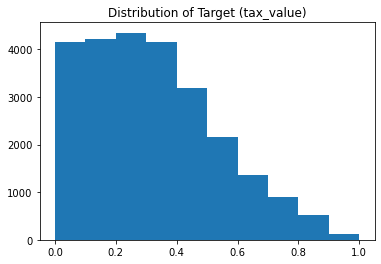

In [57]:
# how do we determine distribution?
plt.hist(y_train_scaled)
plt.title('Distribution of Target (tax_value)')
plt.show()

## Modeling

### Baseline

We will use MEAN as the baseline for the MVP 

### Features

I will use ['bathrooms', 'sq_ft', 'age'] as my kbest features; ['sq_ft', 'LA', 'Orange'] as my rfe features



## all the X_train/validate/test_kbest/rfe are scaled from X_train/validate/test

In [58]:
X_train_scaled.head(1)

,bedrooms,bathrooms,sq_ft,age,sq_ft_per_bathroom,LA,Orange,Ventura
0,0.333333,0.333333,0.695079,0.589552,0.352915,1.0,0.0,0.0


In [59]:
X_train_scaled.columns

Index(['bedrooms', 'bathrooms', 'sq_ft', 'age', 'sq_ft_per_bathroom', 'LA',
       'Orange', 'Ventura'],
      dtype='object')

In [60]:
X_train_kbest = X_train_scaled.drop(columns = ['bedrooms', 'sq_ft_per_bathroom', 'LA',
       'Orange', 'Ventura'])
X_train_kbest.head(1)

,bathrooms,sq_ft,age
0,0.333333,0.695079,0.589552


In [61]:
X_validate_kbest = X_validate_scaled.drop(columns = ['bedrooms', 'sq_ft_per_bathroom', 'LA',
       'Orange', 'Ventura'])
X_validate_kbest.head(1)

,bathrooms,sq_ft,age
0,0.333333,0.426479,0.38806


In [62]:
X_test_kbest = X_test_scaled.drop(columns = ['bedrooms', 'sq_ft_per_bathroom', 'LA',
       'Orange', 'Ventura'])
X_test_kbest.head(1)

,bathrooms,sq_ft,age
0,0.0,0.241652,0.597015


In [63]:
X_train_rfe = X_train_scaled.drop(columns = ['bedrooms', 'bathrooms', 'age', 'sq_ft_per_bathroom', 'Ventura'])
X_train_rfe.head(1)

,sq_ft,LA,Orange
0,0.695079,1.0,0.0


In [64]:
X_validate_rfe = X_validate_scaled.drop(columns = ['bedrooms', 'bathrooms', 'age', 'sq_ft_per_bathroom', 'Ventura'])
X_validate_rfe.head(1)

,sq_ft,LA,Orange
0,0.426479,0.0,0.0


In [65]:
X_test_rfe = X_test_scaled.drop(columns = ['bedrooms', 'bathrooms', 'age', 'sq_ft_per_bathroom', 'Ventura'])
X_test_rfe.head(1)

,sq_ft,LA,Orange
0,0.241652,1.0,0.0


In [66]:
# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train_scaled.tax_value.mean()
y_train_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean, 2)
y_validate_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean,2)

In [67]:
y_train.mean()

tax_value    363956.463241
dtype: float64

In [68]:
y_train_scaled.mean()

tax_value              0.323661
tax_value_pred_mean    0.320000
dtype: float64

In [69]:
# 3. RMSE of G3_pred_mean
from sklearn.metrics import mean_squared_error


rmse_train = mean_squared_error(y_train_scaled.tax_value,
                                y_train_scaled.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_mean) ** (0.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.21 
Validate/Out-of-Sample:  0.21


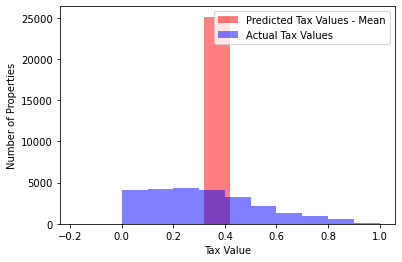

In [70]:

# plot to visualize actual vs predicted. 
plt.hist(y_train_scaled.tax_value_pred_mean, color='red', alpha=.5,  label="Predicted Tax Values - Mean")
plt.hist(y_train_scaled.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
#plt.hist(y_train.G3_pred_median, bins=1, color='orange', alpha=.5, label="Predicted Final Grades - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

In [71]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898


In [72]:
# OLS being run on the KBEST features

# create the model object
lm = LinearRegression()
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_kbest, y_train_scaled.tax_value)
# predict train
y_train_scaled['tax_value_pred_lm_kbest'] = lm.predict(X_train_kbest)
# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lm_kbest) ** .5
# predict validate
y_validate_scaled['tax_value_pred_lm_kbest'] = lm.predict(X_validate_kbest)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm_kbest) ** (0.5)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.18797038659401327 
Validation/Out-of-Sample:  0.18755031547928258


In [73]:
metric_df = metric_df.append({
    'model': 'OLS Regressor Kbest', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550


In [74]:
# OLS being run on the RFE features

# create the model object
lm = LinearRegression()
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_rfe, y_train_scaled.tax_value)
# predict train
y_train_scaled['tax_value_pred_lm_rfe'] = lm.predict(X_train_rfe)
# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lm_rfe) ** .5
# predict validate
y_validate_scaled['tax_value_pred_lm_rfe'] = lm.predict(X_validate_rfe)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm_rfe) ** (0.5)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1863801975623894 
Validation/Out-of-Sample:  0.18551133760941735


In [75]:
metric_df = metric_df.append({
    'model': 'OLS Regressor RFE', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511


In [76]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

#THIS IS LARS WITH KBEST

# a good balance is a low rmse and a low difference

lars = LassoLars(alpha= 1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_kbest, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_lars_kbest'] = lars.predict(X_train_kbest)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lars_kbest) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_lars_kbest'] = lars.predict(X_validate_kbest)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lars_kbest) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

RMSE for Lasso + Lars
Training/In-Sample:  0.208851026311185 
Validation/Out-of-Sample:  0.20888772710086762 
Difference:  3.670078968262547e-05


In [77]:
metric_df = metric_df.append({
    'model': 'lasso_alpha1_kbest', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888


In [78]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# THIS IS LARS WITH RFE


# a good balance is a low rmse and a low difference

lars = LassoLars(alpha= .1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_kbest, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_lars_rfe'] = lars.predict(X_train_rfe)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lars_rfe) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_lars_rfe'] = lars.predict(X_validate_rfe)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lars_rfe) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

RMSE for Lasso + Lars
Training/In-Sample:  0.208851026311185 
Validation/Out-of-Sample:  0.20888772710086762 
Difference:  3.670078968262547e-05


In [79]:
metric_df = metric_df.append({
    'model': 'lasso_alpha1_rfe', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888


In [80]:
# Tweedie on KBEST features:

# as seen in curriculum, the power ought to be set per distribution type
# power = 0 is same as OLS

glm = TweedieRegressor(power=1.4, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_kbest, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_glm_kbest'] = glm.predict(X_train_kbest)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_glm_kbest) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_glm_kbest'] = glm.predict(X_validate_kbest)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_glm_kbest) ** (1/2)

print("RMSE for GLM using Tweedie, power=1.5 & alpha=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1.5 & alpha=2
Training/In-Sample:  0.18799239391970954 
Validation/Out-of-Sample:  0.18731137383197785


In [81]:
metric_df = metric_df.append({
    'model': 'glm_compount_kbest', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888
5,glm_compount_kbest,0.187992,0.187311


In [82]:
# Tweedie on KBEST features:

# as seen in curriculum, the power ought to be set per distribution type
# power = 0 is same as OLS

glm = TweedieRegressor(power=1.5, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_rfe, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_glm_rfe'] = glm.predict(X_train_rfe)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_glm_rfe) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_glm_rfe'] = glm.predict(X_validate_rfe)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_glm_rfe) ** (1/2)

print("RMSE for GLM using Tweedie, power=1.5 & alpha=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1.5 & alpha=2
Training/In-Sample:  0.18613215839670247 
Validation/Out-of-Sample:  0.1850473987351743


In [83]:
metric_df = metric_df.append({
    'model': 'glm_compount_rfe', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888
5,glm_compount_kbest,0.187992,0.187311
6,glm_compount_rfe,0.186132,0.185047


In [84]:
# make the polynomial features to get a new set of features. import from sklearn
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2_kbest = pf.fit_transform(X_train_kbest)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2_kbest = pf.transform(X_validate_kbest)
X_test_degree2_kbest =  pf.transform(X_test_kbest)

In [85]:
# kbest features here:


# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2_kbest, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_lm2_kbest'] = lm2.predict(X_train_degree2_kbest)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lm2_kbest) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_lm2_kbest'] = lm2.predict(X_validate_degree2_kbest)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm2_kbest) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.1870648945099664 
Validation/Out-of-Sample:  0.18661639653183537


In [86]:
metric_df = metric_df.append({
    'model': 'quadratic_kbest', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888
5,glm_compount_kbest,0.187992,0.187311
6,glm_compount_rfe,0.186132,0.185047
7,quadratic_kbest,0.187065,0.186616


In [87]:
# make the polynomial features to get a new set of features. import from sklearn
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2_rfe = pf.fit_transform(X_train_rfe)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2_rfe = pf.transform(X_validate_rfe)
X_test_degree2_rfe =  pf.transform(X_test_rfe)

In [88]:
# rfe features here:


# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2_rfe, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_lm2_rfe'] = lm2.predict(X_train_degree2_rfe)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lm2_rfe) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_lm2_rfe'] = lm2.predict(X_validate_degree2_rfe)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm2_rfe) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.18573040401903843 
Validation/Out-of-Sample:  0.18487887876821385


In [89]:
metric_df = metric_df.append({
    'model': 'quadratic_rfe', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888
5,glm_compount_kbest,0.187992,0.187311
6,glm_compount_rfe,0.186132,0.185047
7,quadratic_kbest,0.187065,0.186616
8,quadratic_rfe,0.185730,0.184879


## Model Evaluation

In [90]:
y_validate_scaled.head(10)

,tax_value,tax_value_pred_mean,tax_value_pred_lm_kbest,tax_value_pred_lm_rfe,tax_value_pred_lars_kbest,tax_value_pred_lars_rfe,tax_value_pred_glm_kbest,tax_value_pred_glm_rfe,tax_value_pred_lm2_kbest,tax_value_pred_lm2_rfe
0,0.419182,0.32,0.311176,0.338144,0.323661,0.323661,0.301146,0.324625,0.302140,0.323560
1,0.198708,0.32,0.338680,0.321491,0.323661,0.323661,0.324277,0.308867,0.330958,0.314756
2,0.183361,0.32,0.227114,0.220649,0.323661,0.323661,0.233633,0.231641,0.223943,0.231526
3,0.358875,0.32,0.255712,0.273882,0.323661,0.323661,0.259364,0.270241,0.244164,0.240676
4,0.029471,0.32,0.262370,0.260195,0.323661,0.323661,0.256893,0.259309,0.258531,0.263309
5,0.251963,0.32,0.284279,0.312156,0.323661,0.323661,0.280142,0.301425,0.279489,0.289691
6,0.248253,0.32,0.307806,0.348327,0.323661,0.323661,0.298438,0.336041,0.300445,0.339877
7,0.443807,0.32,0.260954,0.240563,0.323661,0.323661,0.263096,0.245184,0.255475,0.247392
8,0.145799,0.32,0.189234,0.178279,0.323661,0.323661,0.210983,0.205264,0.187719,0.198699
9,0.444147,0.32,0.286926,0.272623,0.323661,0.323661,0.282171,0.268670,0.292186,0.273526


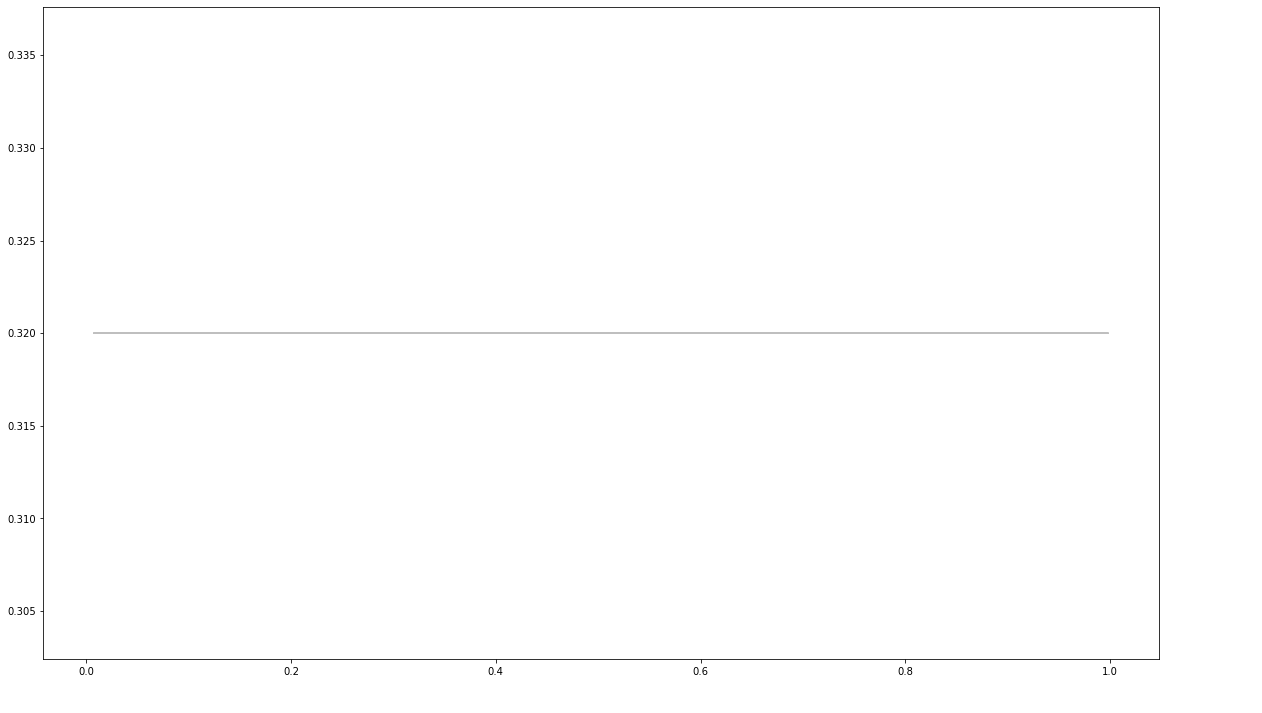

In [105]:
# THIS GRAPHIC DOES NOTHING FOR ME. AXE IT

# y_validate.head()
plt.figure(figsize=(20,12))
plt.plot(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (1,.3))
# plt.plot(y_validate_scaled.tax_value, y_validate_scaled.tax_value, alpha=.5, color="blue", label='_nolegend_')
# plt.annotate("The Ideal Line: Predicted = Actual", (.9,.9), rotation=28)

# plt.scatter(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm_kbest, 
#             alpha=.5, color="red", s=100, label="Model: LinearRegression, KBest Features")
# plt.scatter(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm_rfe, 
#             alpha=.5, color="blue", s=100, label="Model: LinearRegression, RFE Features")
# plt.scatter(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lars_kbest, 
#             alpha=.5, color="yellow", s=100, label="Model: Lars with KBest Features")
# plt.scatter(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lars_rfe, 
#             alpha=.5, color="green", s=100, label="Model: Lars with RFE Features")

# plt.legend()
# plt.xlabel("Actual Tax Value")
# plt.ylabel("Predicted Tax Value")
# plt.title("Where are predictions more extreme? More modest?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

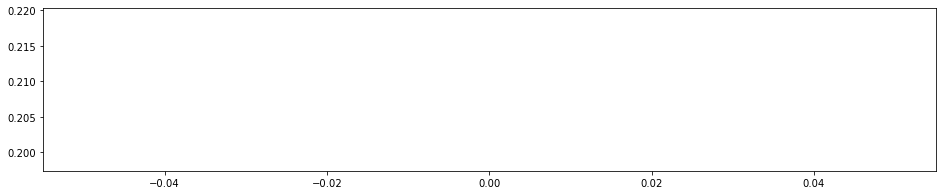

In [113]:
plt.figure(figsize=(16,3))
plt.plot(metric_df.iloc[0].RMSE_train, alpha=.5, color="gray", label='_nolegend_')
# sns.barplot(x = 'model',y = metric_df.RMSE_train, data=metric_df)
# plt.tight_layout

In [115]:
y_test_scaled

,tax_value
0,0.121779
1,0.200872
2,0.323217
3,0.488671
4,0.246407
...,...
8968,0.579203
8969,0.360031
8970,0.235647
8971,0.416229


In [87]:
# make the polynomial features to get a new set of features. import from sklearn
# pf = PolynomialFeatures(degree=2)

# # fit and transform X_train_scaled
# X_test_degree2_rfe = pf.fit_transform(X_test_rfe)

# # transform X_validate_scaled & X_test_scaled
# X_validate_degree2_rfe = pf.transform(X_validate_rfe)
# X_test_degree2_rfe =  pf.transform(X_test_rfe)

In [120]:
# rfe features here:


# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree2_rfe, y_test_scaled.tax_value)

# predict train
y_test_scaled['tax_value_pred_lm2_rfe'] = lm2.predict(X_test_degree2_rfe)

# evaluate: rmse
rmse_test = mean_squared_error(y_test_scaled.tax_value, y_test_scaled.tax_value_pred_lm2_rfe) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.18573040401903843 
Validation/Out-of-Sample:  0.18402719726701586


In [124]:
print("RMSE for Polynomial Model, degrees=2\nTest/Out of Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test/Out of Sample:  0.18402719726701586


## This beats baseline ; )

In [116]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888
5,glm_compount_kbest,0.187992,0.187311
6,glm_compount_rfe,0.186132,0.185047
7,quadratic_kbest,0.187065,0.186616
8,quadratic_rfe,0.185730,0.184879


In [118]:
(0.208898 - 0.184879) / 0.208898

0.11497955940219634